<a href="https://colab.research.google.com/github/LolloS8/Paper-Replication-/blob/main/Paper_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


A collection of Python implementations of academic papers in quantitative finance. This repository explores and validates pricing, risk management, and machine learning models.

1) "Accelerated American option pricing with deep netwokrs" - Anderson and Urban Ulrych 2023

WARNING: During the dataset generation phase, you may observe several RankWarning: Polyfit may be poorly conditioned messages. This is expected behavior inherent to the Longstaff-Schwartz algorithm.

These warnings occur when the number of In-The-Money (ITM) paths at a specific backward induction step is insufficient to perform a stable polynomial regression (e.g., fewer data points than the polynomial degree). These edge cases are statistically negligible and do not impact the integrity of the generated dataset or the model's accuracy.

In [1]:
# 1. Necessary libraries and plot standards
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import time
from itertools import product
from tqdm import tqdm

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 10,
})

# ------------------------------
# ------------------------------

# 2. Pricing with Heston Model: calculating inputs for the neural network
def heston_american_put_mc_ls(S0, K, T, r, q, v0, kappa, theta, sigma, rho, M, N):
  #print('Calculate the price of an American put option with the Heston model using the Longstaff-Schwartz Monte Carlo method.')

  dt = T / M # temporal dimension of the step

  # 2.1 Paths Simulation for Price and Volatility
  Z1 = np.random.normal(size = (M,N))
  Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size = (M,N))
  S = np.zeros((M + 1 , N))
  v = np.zeros((M + 1 , N))
  S[0, :] = S0
  v[0, :] = v0

  for t in range(M):
    #Variance discretization
    v[t+1, :] = np.maximum(v[t, :] + kappa * (theta - v[t, :]) * dt + sigma * np.sqrt(v[t, :]) * np.sqrt(dt) * Z2[t, :], 0)
    #Asset price discretization
    S[t+1, :] = S[t, :] * np.exp((r - q - 0.5 * v[t, :]) * dt + np.sqrt(v[t, :]) * np.sqrt(dt) * Z1[t, :])

  #2.2 Longstaff-Schwartz Algorithm
  payoff = np.maximum(K - S, 0)
  cash_flows = np.zeros_like(S)
  cash_flows[M, :] = payoff[M, :]

  for t in range (M - 1, 0, -1):
    #For this implementation, the discount factor is:
    df = np.exp(-r * dt)

    #ITM Paths
    itm_paths = np.where(payoff[t, :] > 0)[0]

    if len(itm_paths) > 0:
      exercise_value = payoff[t, itm_paths]

      #Future Cash Flow Regression
      future_cash_flows = cash_flows[t+1, itm_paths] * df
      X = S[t, itm_paths]

      coeffs = np.polyfit(X, future_cash_flows, 2)
      continuation_value = np.polyval(coeffs, X)

      exercise_now = exercise_value > continuation_value

      #Cash Flow upgrade
      cash_flows[t, :] = cash_flows[t+1, :] * df #This is for the paths where we do not exercise
      cash_flows[t, itm_paths[exercise_now]] = exercise_value[exercise_now] #This is for the paths where we exercise

  # 3. Final Price Value
  option_price = np.mean(cash_flows[1, :] * np.exp(-r * dt))
  return option_price

## Example Function Test ##
if __name__ == '__main__':
  S0 = 100
  K = 100
  T = 1.0
  r = 0.01
  q = 0.03

  # Heston Model parameter
  v0 = 0.04
  kappa = 2.0
  theta = 0.09
  sigma = 0.5
  rho = -0.7

  M_sim = 100 #Temporal Paths
  N_sim = 20000 #Simulations

  start_time = time.time()
  price = heston_american_put_mc_ls(S0, K, T, r, q, v0, kappa, theta, sigma, rho, M_sim, N_sim)
  end_time = time.time()

  print(f'American Put Option Price:{price:.4f}')
  print(f'Run Time: {end_time - start_time:.2f} seconds')

## -- DATA SET CREATION -- ##

import pandas as pd
from itertools import product
from tqdm import tqdm

# 1. Parameters
num_points = 5 #This is a semplifiation. For the paper must be 12

## Pamaters space
param_grid = {
    'S0': np.linspace(90, 110, num_points),
    'T': np.linspace(1, 255, num_points) / 252,
    'v0': np.logspace(np.log10(0.01), np.log10(0.41), num_points),
    'kappa': np.linspace(0.1, 5, num_points),
    'theta': np.logspace(np.log10(0.01), np.log10(0.41), num_points),
    'sigma': np.linspace(0.1, 1, num_points),
    'rho': np.linspace(-0.99, -0.1, num_points)
}

K = 100.0
r = 0.01
q = 0.03

M_gen = 50
N_gen = 10000 #These are Monte Carlo parameters for the simulation

# 2. Generation of Combinations
keys, values = zip(*param_grid.items()) #zip is used to combine elements from multiple iterable objects (such as lists, strings, or tuples) into a single tuple iterator, pairing the elements based on their position.
combinations = [dict(zip(keys, v)) for v in product(*values)] #zip match paramters couple; dict converts these couples into dictionary
df = pd.DataFrame(combinations)

print(f'Data set size: {df.shape[0]}')
print(f'Price Generation... it requires a lot of times')

# 3. Price Calculation
prices = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Apply Feller's condition to avoid invalid parameters [cite: 162]
    if 2 * row['kappa'] * row['theta'] > row['sigma']**2:
        price = heston_american_put_mc_ls(
            S0=row['S0'], K=K, T=row['T'], r=r, q=q,
            v0=row['v0'], kappa=row['kappa'], theta=row['theta'],
            sigma=row['sigma'], rho=row['rho'],
            M=M_gen, N=N_gen
        )
        prices.append(price)
    else:
        # If the condition is not respected -> NaN
        prices.append(np.nan)

df['Price'] = prices
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(f'\nGeneration completed. Final dataset with {len(df)} samples.')

# 4. Save the Dataset
output_filename = 'heston_american_put_dataset.csv'
df.to_csv(output_filename, index=False)

print("\nPreview of the generated dataset:")
print(df.head())
print(f"File '{output_filename}' Saved.")


American Put Option Price:10.5454
Run Time: 0.41 seconds
Data set size: 78125
Price Generation... it requires a lot of times


Output streaming troncato alle ultime 5000 righe.
 84%|████████▎ | 65241/78125 [37:17<07:01, 30.60it/s]/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, future_cash_flows, 2)
/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, future_cash_flows, 2)
/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, future_cash_flows, 2)
/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, future_cash_flows, 2)
/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, future_cash_flows, 2)
/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, future_cash_flows, 2)
/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, fu


Generation completed. Final dataset with 39375 samples.

Preview of the generated dataset:
     S0         T    v0  kappa     theta  sigma     rho      Price
0  90.0  0.003968  0.01    0.1  0.064031    0.1 -0.9900  10.008433
1  90.0  0.003968  0.01    0.1  0.064031    0.1 -0.7675  10.003183
2  90.0  0.003968  0.01    0.1  0.064031    0.1 -0.5450  10.008825
3  90.0  0.003968  0.01    0.1  0.064031    0.1 -0.3225  10.002531
4  90.0  0.003968  0.01    0.1  0.064031    0.1 -0.1000  10.007491
File 'heston_american_put_dataset.csv' Saved.


The log indicates:

Generation completed. Final dataset with 39375 samples.

This is a crucial outcome. We started with a total of 78,125 potential parameter combinations (5^7). The final dataset contains only 39,375 samples because approximately 50% of the initial combinations were filtered out.

This means that on 78,125 parameters combinations, only 39,375 respect Feller'condition.
The next step will consist of calibrating the Neural Network and watch if it is able to replicate price column.

Data has been divided in 31500 samples for training and 7875 samples for testing

Data successfully prepared and normalized


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 40)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,921 (27.04 KB)

 Trainable params: 6,921 (27.04 KB)

 Non-trainable params: 0 (0.00 B)


Model compiled, begin with training
Epoch 1/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.1310 - mean_absolute_error: 4.1310 - val_loss: 1.0062 - val_mean_absolute_error: 1.0062
Epoch 2/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8591 - mean_absolute_error: 0.8591 - val_loss: 0.9318 - val_mean_absolute_error: 0.9318
Epoch 3/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5965 - mean_absolute_error: 0.5965 - val_loss: 0.4990 - val_mean_absolute_error: 0.4990
Epoch 4/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4618 - mean_absolute_error: 0.4618 - val_loss: 0.4235 - val_mean_absolute_error: 0.4235
Epoch 5/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4154 - mean_absolute_error: 0.4154 - val_loss: 0.4042 - val_mean_absolute_error: 0.4042
Epoch 6/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3613 - mean_absolute_error: 0.3613 - val_loss: 0.3516 - val_mean_absolute_error: 0.3516
Epoch 7/100
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

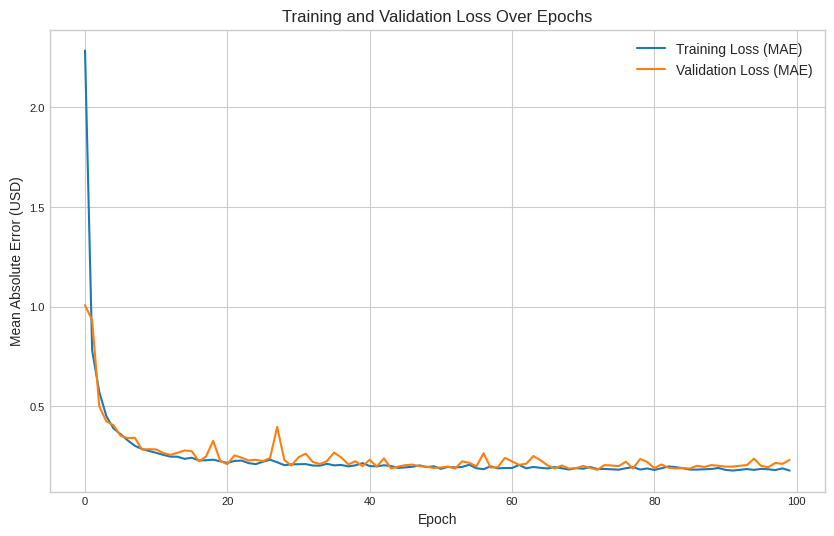

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Price implementation with Monte Carlo...


/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, future_cash_flows, 2)


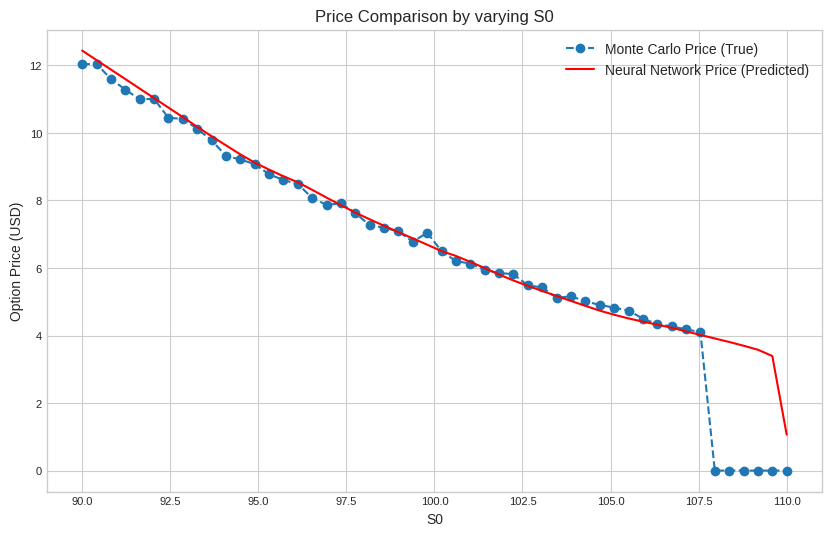

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Calculating 'true' prices with Monte Carlo method for comparison...


/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, future_cash_flows, 2)
/tmp/ipython-input-2685275422.py:66: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(X, future_cash_flows, 2)


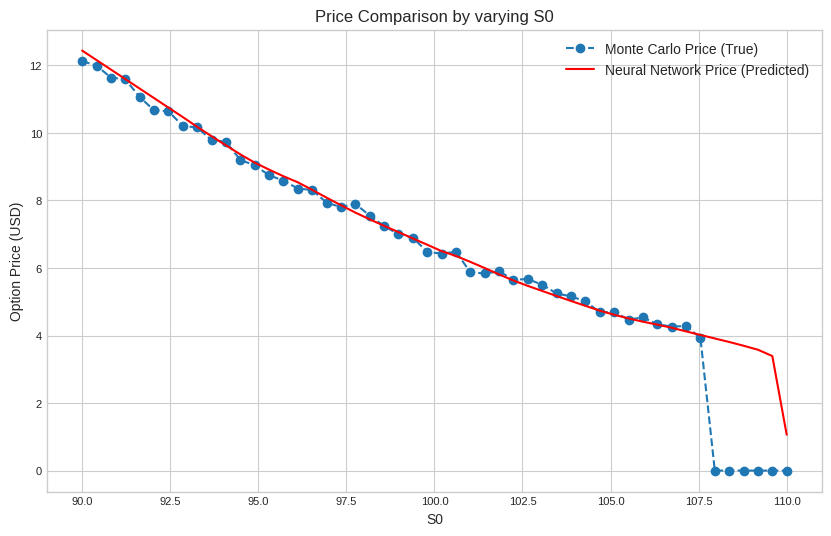

In [4]:
# 1. Necessary libraries and plot standards
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# 1. Uploading Data
data = pd.read_csv('heston_american_put_dataset.csv')

# 2. Features and Target
X = data.drop('Price', axis = 1) #build a dataframe without 'price' column
y = data['Price']

# 3. Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(f'Data has been divided in {len(X_train)} samples for training and {len(X_test)} samples for testing')

# 3. Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #It learns scaling rules from the data and then transforms them. It is only used on the training set.
X_test_scaled = scaler.transform(X_test) #It applies only the scaling rules already learned. It is used on all subsequent data (e.g., the test set).
print('\nData successfully prepared and normalized')

# 4. Neural Network Architecture
model = Sequential([
    Dense(40, input_dim = X_train_scaled.shape[1]),
    LeakyReLU(alpha = 0.01),

    # 4.1 Hidden Layers
    Dense(40),
    LeakyReLU(alpha=0.01),
    Dense(40),
    LeakyReLU(alpha=0.01),
    Dense(40),
    LeakyReLU(alpha=0.01),
    Dense(40),
    LeakyReLU(alpha=0.01),

    # Output layer
    Dense(1, activation = 'linear') #Price layer
])
model.summary()

# 5. Training Model
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'mean_absolute_error',
    metrics = ['mean_absolute_error']
)
print('\nModel compiled, begin with training')

history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    epochs = 100,
    batch_size = 64,
    verbose = 1 #progress visualization
)
print('\nModel training completed')

####################
####################
####################

import matplotlib.pyplot as plt



# 1. Output visualization
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'], label = 'Training Loss (MAE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (USD)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualization of the results
base_params = {
    'S0': 100.0, 'K': 100.0, 'T': 120/252, 'r': 0.01, 'q': 0.03,
    'v0': 0.04, 'kappa': 2.0, 'theta': 0.09, 'sigma': 0.5, 'rho': -0.7
}

param_to_vary = 'S0'
vary_range = np.linspace(90, 110, 50) # 50 value for S0 and K

test_data = []
for val in vary_range:
    params = base_params.copy()
    params[param_to_vary] = val
    # Delete fixed params from the model
    model_inputs = {k: v for k, v in params.items() if k in X.columns}
    test_data.append(model_inputs)

test_df = pd.DataFrame(test_data)


test_df_scaled = scaler.transform(test_df)
nn_predictions = model.predict(test_df_scaled).flatten()

print("Price implementation with Monte Carlo...")
mc_prices = [heston_american_put_mc_ls(M=50, N=10000, K=100.0, r=0.01, q=0.03, **params) for params in test_data]

plt.figure(figsize=(10, 6))
plt.plot(vary_range, mc_prices, label='Monte Carlo Price (True)', linestyle='--', marker='o')
plt.plot(vary_range, nn_predictions, label='Neural Network Price (Predicted)', color='red')
plt.title(f'Price Comparison by varying {param_to_vary}')
plt.xlabel(param_to_vary)
plt.ylabel('Option Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
import time
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Step 4.2: Qualitative Analysis

# 1. Base case scenario
base_params = {
    'S0': 100.0, 'K': 100.0, 'T': 120/252, 'r': 0.01, 'q': 0.03,
    'v0': 0.04, 'kappa': 2.0, 'theta': 0.09, 'sigma': 0.5, 'rho': -0.7
}

# 2. Parameter to vary (e.g., S0)
param_to_vary = 'S0'
vary_range = np.linspace(90, 110, 50)

# 3. Prepare data for both the NN and the MC pricer
# This list will hold the FULL dictionaries for the Monte Carlo function
full_params_list = []
for val in vary_range:
    params = base_params.copy()
    params[param_to_vary] = val
    full_params_list.append(params)

# This DataFrame holds ONLY the inputs for the Neural Network
nn_input_df = pd.DataFrame(full_params_list)[list(X.columns)]

# 4. Scale data and get NN predictions
nn_input_scaled = scaler.transform(nn_input_df)
nn_predictions = model.predict(nn_input_scaled).flatten()

# 5. Calculate "true" prices using the list with the complete dictionaries
print("Calculating 'true' prices with Monte Carlo method for comparison...")
mc_prices = [heston_american_put_mc_ls(M=50, N=10000, K=100.0, r=0.01, q=0.03, **params) for params in test_data]

# 6. Plotting the comparison
plt.figure(figsize=(10, 6))
plt.plot(vary_range, mc_prices, label='Monte Carlo Price (True)', linestyle='--', marker='o')
plt.plot(vary_range, nn_predictions, label='Neural Network Price (Predicted)', color='red')
plt.title(f'Price Comparison by varying {param_to_vary}')
plt.xlabel(param_to_vary)
plt.ylabel('Option Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

The most important metric is the error on the test set (val_loss), which is a Mean Absolute Error (MAE) of approximately $0.21. This means that, on average, our fast model's predictions deviate by only 21 cents from the "correct" price calculated by the slow model (Monte Carlo).

 The error on the test data (val_loss: 0.2080) is very close to the error on the training data (loss: 0.1931). This is a very good sign, as it suggests that the model hasn't simply memorized the data, but is able to generalize well to examples it has never seen before, without severe overfitting.